In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(tidyr)))
suppressPackageStartupMessages(suppressWarnings(library(reshape2)))
suppressPackageStartupMessages(suppressWarnings(library(stringr))) # string manipulation
suppressPackageStartupMessages(suppressWarnings(library(patchwork)))
suppressPackageStartupMessages(suppressWarnings(library(cowplot)))
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML)))
suppressPackageStartupMessages(suppressWarnings(library(pheatmap)))
suppressPackageStartupMessages(suppressWarnings(library(lattice)))
suppressPackageStartupMessages(suppressWarnings(library("RColorBrewer")))
suppressPackageStartupMessages(suppressWarnings(library(gplots)))
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap)))
suppressPackageStartupMessages(suppressWarnings(library(ggplotify)))
suppressPackageStartupMessages(suppressWarnings(library(arrow)))
suppressPackageStartupMessages(suppressWarnings(library(scales)))
suppressPackageStartupMessages(suppressWarnings(library(circlize)))
suppressPackageStartupMessages(suppressWarnings(library(purrr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(Polychrome)))


# check if ggmagnify is installed, if not install it
if (!requireNamespace("ggmagnify", quietly = TRUE)) {
  install.packages("ggmagnify", repos = c("https://hughjonesd.r-universe.dev", 
                 "https://cloud.r-project.org"))
}
suppressPackageStartupMessages(suppressWarnings(library(ggmagnify)))
source("../../utils/figure_themes.r")


## Generate each individual plot prior to combining them in a single figure (pathwork)

In [2]:
# Load in the treatment list
toml_path <- file.path("..","..","..","1.Exploratory_Data_Analysis/utils/params.toml")
p <- parseTOML(toml_path)
# get the list that is in the toml file under the key "treatments"
# define that list as a variable called list_of_treatments and print the list to verify
list_of_treatments <- c(p$list_of_treatments$treatments)



In [3]:
# Figure 2A

# Load data
data_path_cytokine_values <- file.path("../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_PBMC_clean.parquet")
cytokine_values <- arrow::read_parquet(data_path_cytokine_values)
# filter out the treatments that are not in the list
cytokine_values <- cytokine_values[cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments,]

# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)



In [4]:
# convert to a dataframe
cytokine_values <- as.data.frame(cytokine_values)
head(cytokine_values,2)

# make a new column that is the treatment group based on the ground truth data
cytokine_values$group <- ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cytokine_values$group <- factor(cytokine_values$group, levels = c("Control","Apoptosis", "Pyroptosis"))


,plate_name,plate_barcode,position_x,cell_type,incubation inducer,inhibitor,inhibitor_concentration_value,inhibitor_concentration_unit,inhibitor_concentration,inducer1,⋯,VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],Treatment,Dose,oneb_Treatment_Dose_Inhibitor_Dose,twob_Treatment_Dose_Inhibitor_Dose,threeb_Treatment_Dose_Inhibitor_Dose,fourb_Treatment_Dose_Inhibitor_Dose
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,70117_20230210MM1_P1,430420,B06,PBMC,6_h,DMSO,0.025,%,0.030,DMSO,⋯,0.2588339,0.2383579,0.5242758,0.2506705,DMSO,0.100_%,DMSO_0.100_%_DMSO_0.025_%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030
2,70117_20230210MM1_P1,430420,C06,PBMC,6_h,DMSO,0.025,%,0.030,DMSO,⋯,0.3811698,0.1686448,0.4550923,0.2287523,DMSO,0.100_%,DMSO_0.100_%_DMSO_0.025_%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030


In [5]:
# mutate the names of each treatment
cytokine_values <- cytokine_values %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose == "DMSO_0.100_%_DMSO_0.025_%" ~ "DMSO 0.1%",
        oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.025_%" ~ "Flagellin 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM"
    ))


In [6]:
# create grouping of treatment and group
cytokine_values$group_treatment <- paste(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose, cytokine_values$group,  sep = ", ")
# make the group_treatment column a factor
cytokine_values$group_treatment <- factor(
    cytokine_values$group_treatment, 
    levels = c(
        'DMSO 0.1%, Control',
        'Flagellin 0.1 ug/ml, Control',
        'Flagellin 1.0 ug/ml, Pyroptosis',
        'LPS 0.01 ug/ml, Pyroptosis',
        'LPS 0.1 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml, Pyroptosis',
        'LPS 10.0 ug/ml, Pyroptosis',
        'LPS 100.0 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis',
        'H2O2 100.0 nM, Control',
        'H2O2 100.0 uM, Control',
        'Thapsigargin 1.0 uM, Apoptosis',
        'Thapsigargin 10.0 uM, Apoptosis'
    )
)
unique(cytokine_values$group_treatment)

[1] DMSO 0.1%, Control                           
 [2] Flagellin 1.0 ug/ml, Pyroptosis              
 [3] LPS 0.01 ug/ml, Pyroptosis                   
 [4] LPS 0.1 ug/ml, Pyroptosis                    
 [5] <NA>                                         
 [6] LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis 
 [7] LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis
 [8] LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis 
 [9] LPS 1.0 ug/ml, Pyroptosis                    
[10] Thapsigargin 1.0 uM, Apoptosis               
[11] LPS 10.0 ug/ml, Pyroptosis                   
[12] Thapsigargin 10.0 uM, Apoptosis              
[13] H2O2 100.0 nM, Control                       
[14] LPS 100.0 ug/ml, Pyroptosis                  
[15] H2O2 100.0 uM, Control                       
15 Levels: DMSO 0.1%, Control ... Thapsigargin 10.0 uM, Apoptosis

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


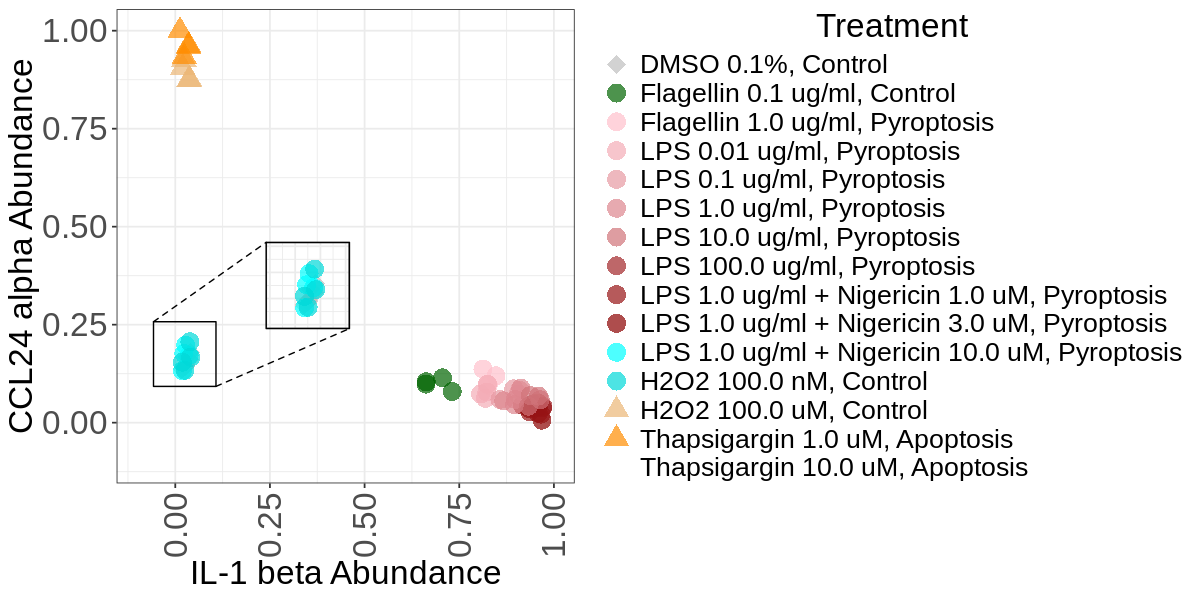

In [7]:
# set plot size
width <- 8.5
height <- 8.5
options(repr.plot.width=width, repr.plot.height=height)
cytokine_scatter_plot1 <- (
    ggplot(
        data = cytokine_values,
        aes(
            x = `IL-1 beta [NSU]`,
            y = `CCL24 [NSU]`,
            color = group_treatment,
            shape = group_treatment
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + xlab("IL-1 beta Abundance")
    + ylab("CCL24 alpha Abundance")
    + xlim(-0.1, 1)
    + ylim(-0.1, 1)
    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
        + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Treatment",
        labels = c(
        'DMSO 0.1%, Control',
        'Flagellin 0.1 ug/ml, Control',
        'Flagellin 1.0 ug/ml, Pyroptosis',
        'LPS 0.01 ug/ml, Pyroptosis',
        'LPS 0.1 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml, Pyroptosis',
        'LPS 10.0 ug/ml, Pyroptosis',
        'LPS 100.0 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis',
        'H2O2 100.0 nM, Control',
        'H2O2 100.0 uM, Control',
        'Thapsigargin 1.0 uM, Apoptosis',
        'Thapsigargin 10.0 uM, Apoptosis'
        ),
        values = colors_2)
    + scale_shape_manual(
        name = "Treatment",
        labels = c(
        'DMSO 0.1%, Control',
        'Flagellin 0.1 ug/ml, Control',
        'Flagellin 1.0 ug/ml, Pyroptosis',
        'LPS 0.01 ug/ml, Pyroptosis',
        'LPS 0.1 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml, Pyroptosis',
        'LPS 10.0 ug/ml, Pyroptosis',
        'LPS 100.0 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis',
        'H2O2 100.0 nM, Control',
        'H2O2 100.0 uM, Control',
        'Thapsigargin 1.0 uM, Apoptosis',
        'Thapsigargin 10.0 uM, Apoptosis'
        ),
        values = shapes_2)
    

)

options(repr.plot.width=10, repr.plot.height=5)
# cytokine_scatter_plot
from <- list(-0.05, 0.1, 0.1, 0.25) #xmin, xmax, ymin, ymax
to <- list(0.25,0.45, 0.25, 0.45)
cytokine_scatter_plot1 <- cytokine_scatter_plot1 + geom_magnify(
    from = from, to = to
)
cytokine_scatter_plot1


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


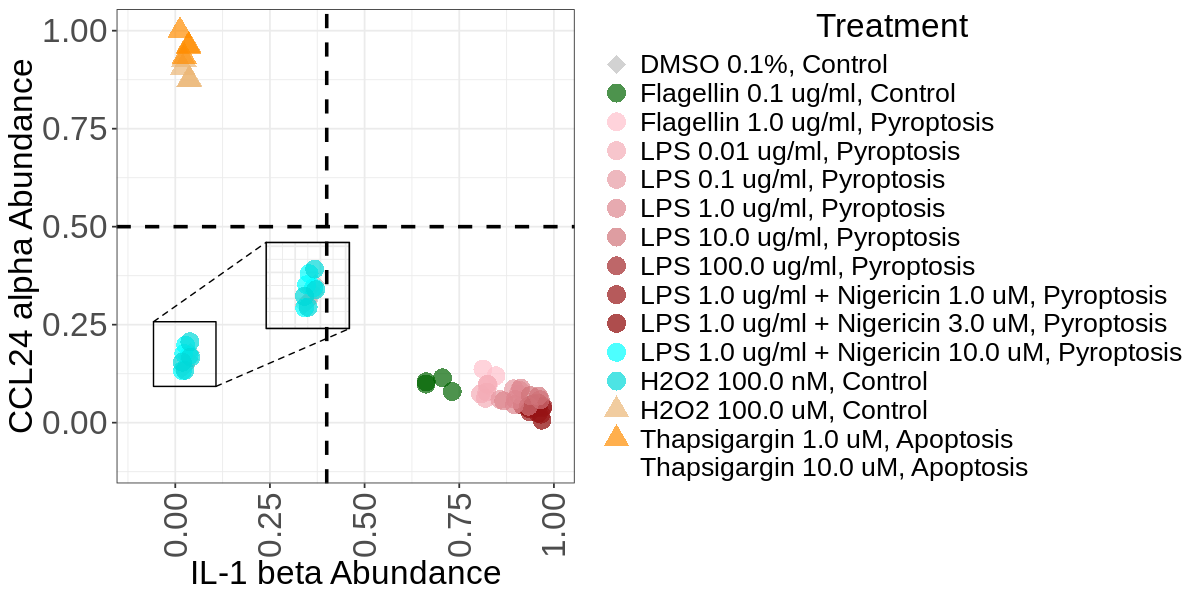

In [8]:
# cytokine_scatter_plot add gates 
cytokine_scatter_plot1 <- (
    cytokine_scatter_plot1
    + geom_vline(xintercept = 0.4, linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1)
)
cytokine_scatter_plot1

## unfiltered Gating

In [9]:

# Load data
data_path_cytokine_values <- file.path("../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_PBMC_clean.parquet")
cytokine_values <- arrow::read_parquet(data_path_cytokine_values)
# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)



In [10]:
# convert to a dataframe
cytokine_values <- as.data.frame(cytokine_values)

# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%
cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose <- ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.0_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
cytokine_values$group <- ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cytokine_values$group <- factor(cytokine_values$group, levels = c("Control","Apoptosis", "Pyroptosis"))

In [11]:
unique(cytokine_values$group)

[1] Control    Pyroptosis Apoptosis 
Levels: Control Apoptosis Pyroptosis

In [12]:
# mutate the names of each treatment

cytokine_values <- cytokine_values %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.0%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media ctr 0.0 0",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_0.0_0' ~ "Media ctr 0.0 0"
    ))
    # replace Media ctr 0.0 0 with Media
cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose <- gsub("Media ctr 0.0 0", "Media - ", cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose)
unique(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose)
# split the oneb_Treatment_Dose_Inhibitor_Dose column into two columns seperated by " - "


[1] "DMSO 0.1% - DMSO 0.025%"                               
 [2] "DMSO 0.1% - DMSO 1.0%"                                 
 [3] "DMSO 0.1% - Z-VAD-FMK 100.0 uM"                        
 [4] "DMSO 0.1% - Z-VAD-FMK 30.0 uM"                         
 [5] "Flagellin 1.0 ug/ml - DMSO 0.025%"                     
 [6] "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM"               
 [7] "LPS 0.01 ug/ml - DMSO 0.025%"                          
 [8] "LPS 0.1 ug/ml - DMSO 0.025%"                           
 [9] "Flagellin 0.1 ug/ml - DMSO 0.025%"                     
[10] "Disulfiram 0.1 uM - DMSO 0.025%"                       
[11] "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"        
[12] "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"       
[13] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM" 
[14] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM"
[15] "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"        
[16] "LPS 1.0 ug/ml - DMSO 0.025%"                           
[17] "Disulfiram 1.0 uM - DMSO 0.025%"                       
[18] "Thapsigargin 1.0 uM - DMSO 0.025%"                     
[19] "Topotecan 10.0 nM - DMSO 0.025%"                       
[20] "LPS 10.0 ug/ml - DMSO 0.025%"                          
[21] "LPS 10.0 ug/ml - Disulfiram 0.1 uM"                    
[22] "LPS 10.0 ug/ml - Disulfiram 1.0 uM"                    
[23] "LPS 10.0 ug/ml - Disulfiram 2.5 uM"                    
[24] "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM"                   
[25] "Thapsigargin 10.0 uM - DMSO 0.025%"                    
[26] "H2O2 100.0 nM - DMSO 0.025%"                           
[27] "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"      
[28] "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"     
[29] "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"      
[30] "LPS 100.0 ug/ml - DMSO 0.025%"                         
[31] "H2O2 100.0 uM - DMSO 0.025%"                           
[32] "H2O2 100.0 uM - Disulfiram 1.0 uM"                     
[33] "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM"                    
[34] "Disulfiram 2.5 uM - DMSO 0.025%"                       
[35] "Topotecan 20.0 nM - DMSO 0.025%"                       
[36] "Topotecan 5.0 nM - DMSO 0.025%"                        
[37] NA

In [13]:
cytokine_values <- cytokine_values %>%
    separate(oneb_Treatment_Dose_Inhibitor_Dose, c("inducer", "inhibitor"), sep = " - ", remove = FALSE)
head(cytokine_values)
cytokine_values$inhibitor <- ifelse(is.na(cytokine_values$inhibitor), "Media", cytokine_values$inhibitor)
unique(cytokine_values$inhibitor)

# make the group_treatment column a factor
cytokine_values$inducer <- factor(
    cytokine_values$inducer,
    levels = c(
        'Media',
        'DMSO 0.1%',

        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',

        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',

        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',

        'LPS 100.0 ug/ml + Nigericin 1.0 uM',
        'LPS 100.0 ug/ml + Nigericin 3.0 uM',
        'LPS 100.0 ug/ml + Nigericin 10.0 uM',

        'H2O2 100.0 nM',
        'H2O2 100.0 uM',

        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',

        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM',

        'Topotecan 5.0 nM',
        'Topotecan 10.0 nM',
        'Topotecan 20.0 nM'
    )
)

# make the group_treatment column a factor
cytokine_values$inhibitor <- factor(
    cytokine_values$inhibitor,
    levels = c(
        'Media',
        'DMSO 0.025%',
        'DMSO 1.0%',

        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',

        'Z-VAD-FMK 30.0 uM',
        'Z-VAD-FMK 100.0 uM'
    )
)

,plate_name,plate_barcode,position_x,cell_type,incubation inducer,inhibitor_concentration_value,inhibitor_concentration_unit,inhibitor_concentration,inducer1,inducer1_concentration_value,⋯,XCL1 (Lymphotactin) [NSU],Treatment,Dose,oneb_Treatment_Dose_Inhibitor_Dose,inducer,inhibitor,twob_Treatment_Dose_Inhibitor_Dose,threeb_Treatment_Dose_Inhibitor_Dose,fourb_Treatment_Dose_Inhibitor_Dose,group
,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
1,70117_20230210MM1_P1,430420,B06,PBMC,6_h,0.025,%,0.030,DMSO,0.1,⋯,0.25067049,DMSO,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,Control
2,70117_20230210MM1_P1,430420,C06,PBMC,6_h,0.025,%,0.030,DMSO,0.1,⋯,0.22875231,DMSO,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,Control
3,70117_20230210MM1_P1,430420,I06,PBMC,6_h,0.025,%,0.030,DMSO,0.1,⋯,0.06464467,DMSO,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,Control
4,70117_20230210MM1_P1,430420,J06,PBMC,6_h,0.025,%,0.030,DMSO,0.1,⋯,0.23419108,DMSO,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,Control
5,70117_20230210MM1_P1,430420,B07,PBMC,6_h,0.025,%,0.030,DMSO,0.1,⋯,0.16707815,DMSO,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,Control
6,70117_20230210MM1_P1,430420,C07,PBMC,6_h,0.025,%,0.030,DMSO,0.1,⋯,0.24460178,DMSO,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,Control


[1] "DMSO 0.025%"        "DMSO 1.0%"          "Z-VAD-FMK 100.0 uM"
[4] "Z-VAD-FMK 30.0 uM"  "Disulfiram 1.0 uM"  "Disulfiram 0.1 uM" 
[7] "Disulfiram 2.5 uM"  "Media"

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


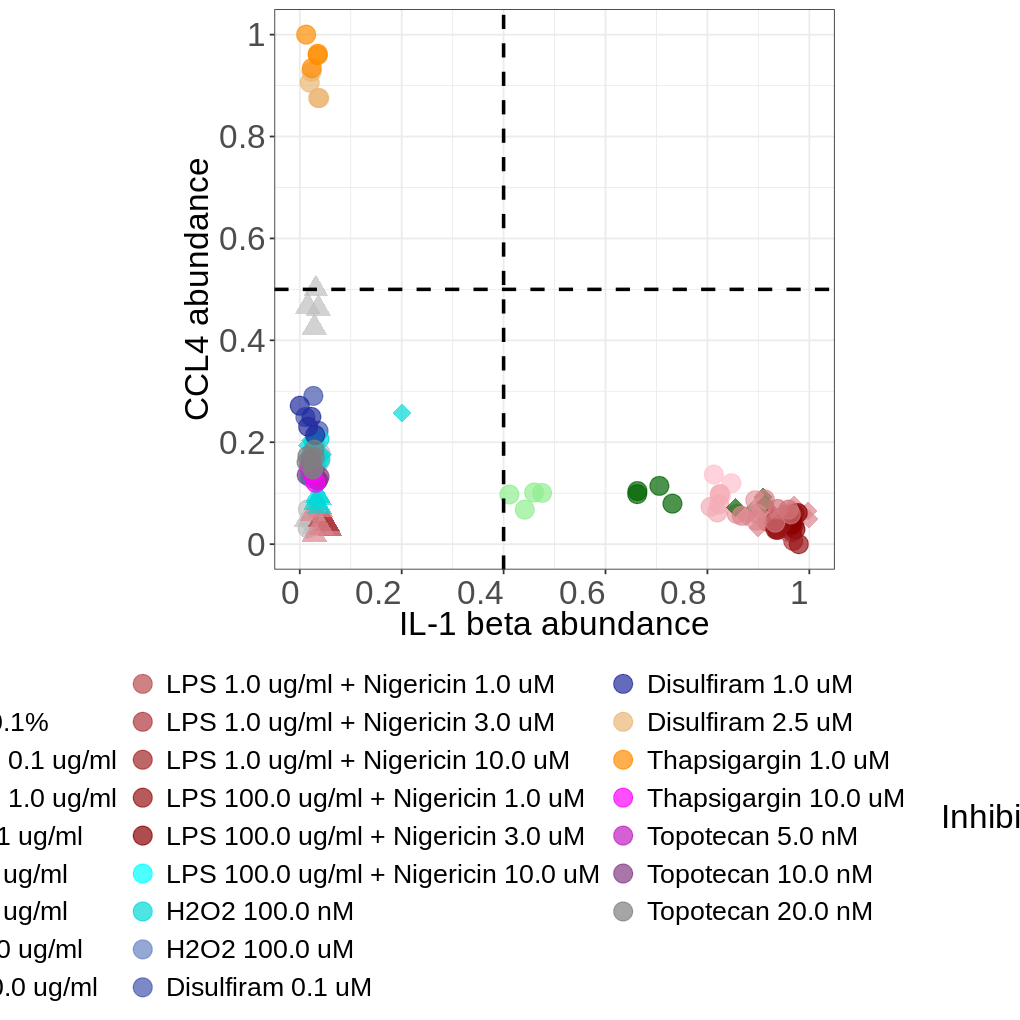

In [14]:
# set plot size
width <- 8.5
height <- 8.5
options(repr.plot.width=width, repr.plot.height=height)

cytokine_scatter_plot1 <- (
    ggplot(
        data = cytokine_values,
        aes(
            x = `IL-1 beta [NSU]`,
            y = `CCL24 [NSU]`,
            color = inducer,
            shape = inhibitor
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + xlab("IL-1 beta abundance")
    + ylab("CCL4 abundance")
    + xlim(-0.1, 1.1)
    + ylim(-0.1, 1.1)
    # x scale breaks
    + scale_x_continuous(
        breaks = seq(0, 1, 0.2),
        labels = seq(0, 1, 0.2)
    )
    # y scale breaks
    + scale_y_continuous(
        breaks = seq(0, 1, 0.2),
        labels = seq(0, 1, 0.2)
    )
    # rotate x axis text
    + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))

    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Inducer",
        labels = c(
            'Media',
            'DMSO 0.1%',

            'Flagellin 0.1 ug/ml',
            'Flagellin 1.0 ug/ml',

            'LPS 0.01 ug/ml',
            'LPS 0.1 ug/ml',
            'LPS 1.0 ug/ml',
            'LPS 10.0 ug/ml',
            'LPS 100.0 ug/ml',

            'LPS 1.0 ug/ml + Nigericin 1.0 uM',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM',

            'LPS 100.0 ug/ml + Nigericin 1.0 uM',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM',

            'H2O2 100.0 nM',
            'H2O2 100.0 uM',

            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Thapsigargin 1.0 uM',
            'Thapsigargin 10.0 uM',

            'Topotecan 5.0 nM',
            'Topotecan 10.0 nM',
            'Topotecan 20.0 nM'
        ),
        values = colors)
    + scale_shape_manual(
        name = "Inhibitor",
        labels = c(
            'Media',
            'DMSO 0.025%',
            'DMSO 1.0%',

            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Z-VAD-FMK 30.0 uM',
            'Z-VAD-FMK 100.0 uM'
        ),
        values = shapes
    )
    + theme(legend.position = "bottom")
    # set the legend columns to 4
    + guides(color = guide_legend(ncol = 3))
    + guides(shape = guide_legend(ncol = 1))
    

)
# cytokine_scatter_plot add gates 
cytokine_scatter_plot1 <- (
    cytokine_scatter_plot1
    + geom_vline(xintercept = 0.4, linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1)
    + ggplot2::coord_fixed()
)
cytokine_scatter_plot1


Warning message in matrix(custom_pallette, ncol = 4):
“data length [37] is not a sub-multiple or multiple of the number of rows [10]”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


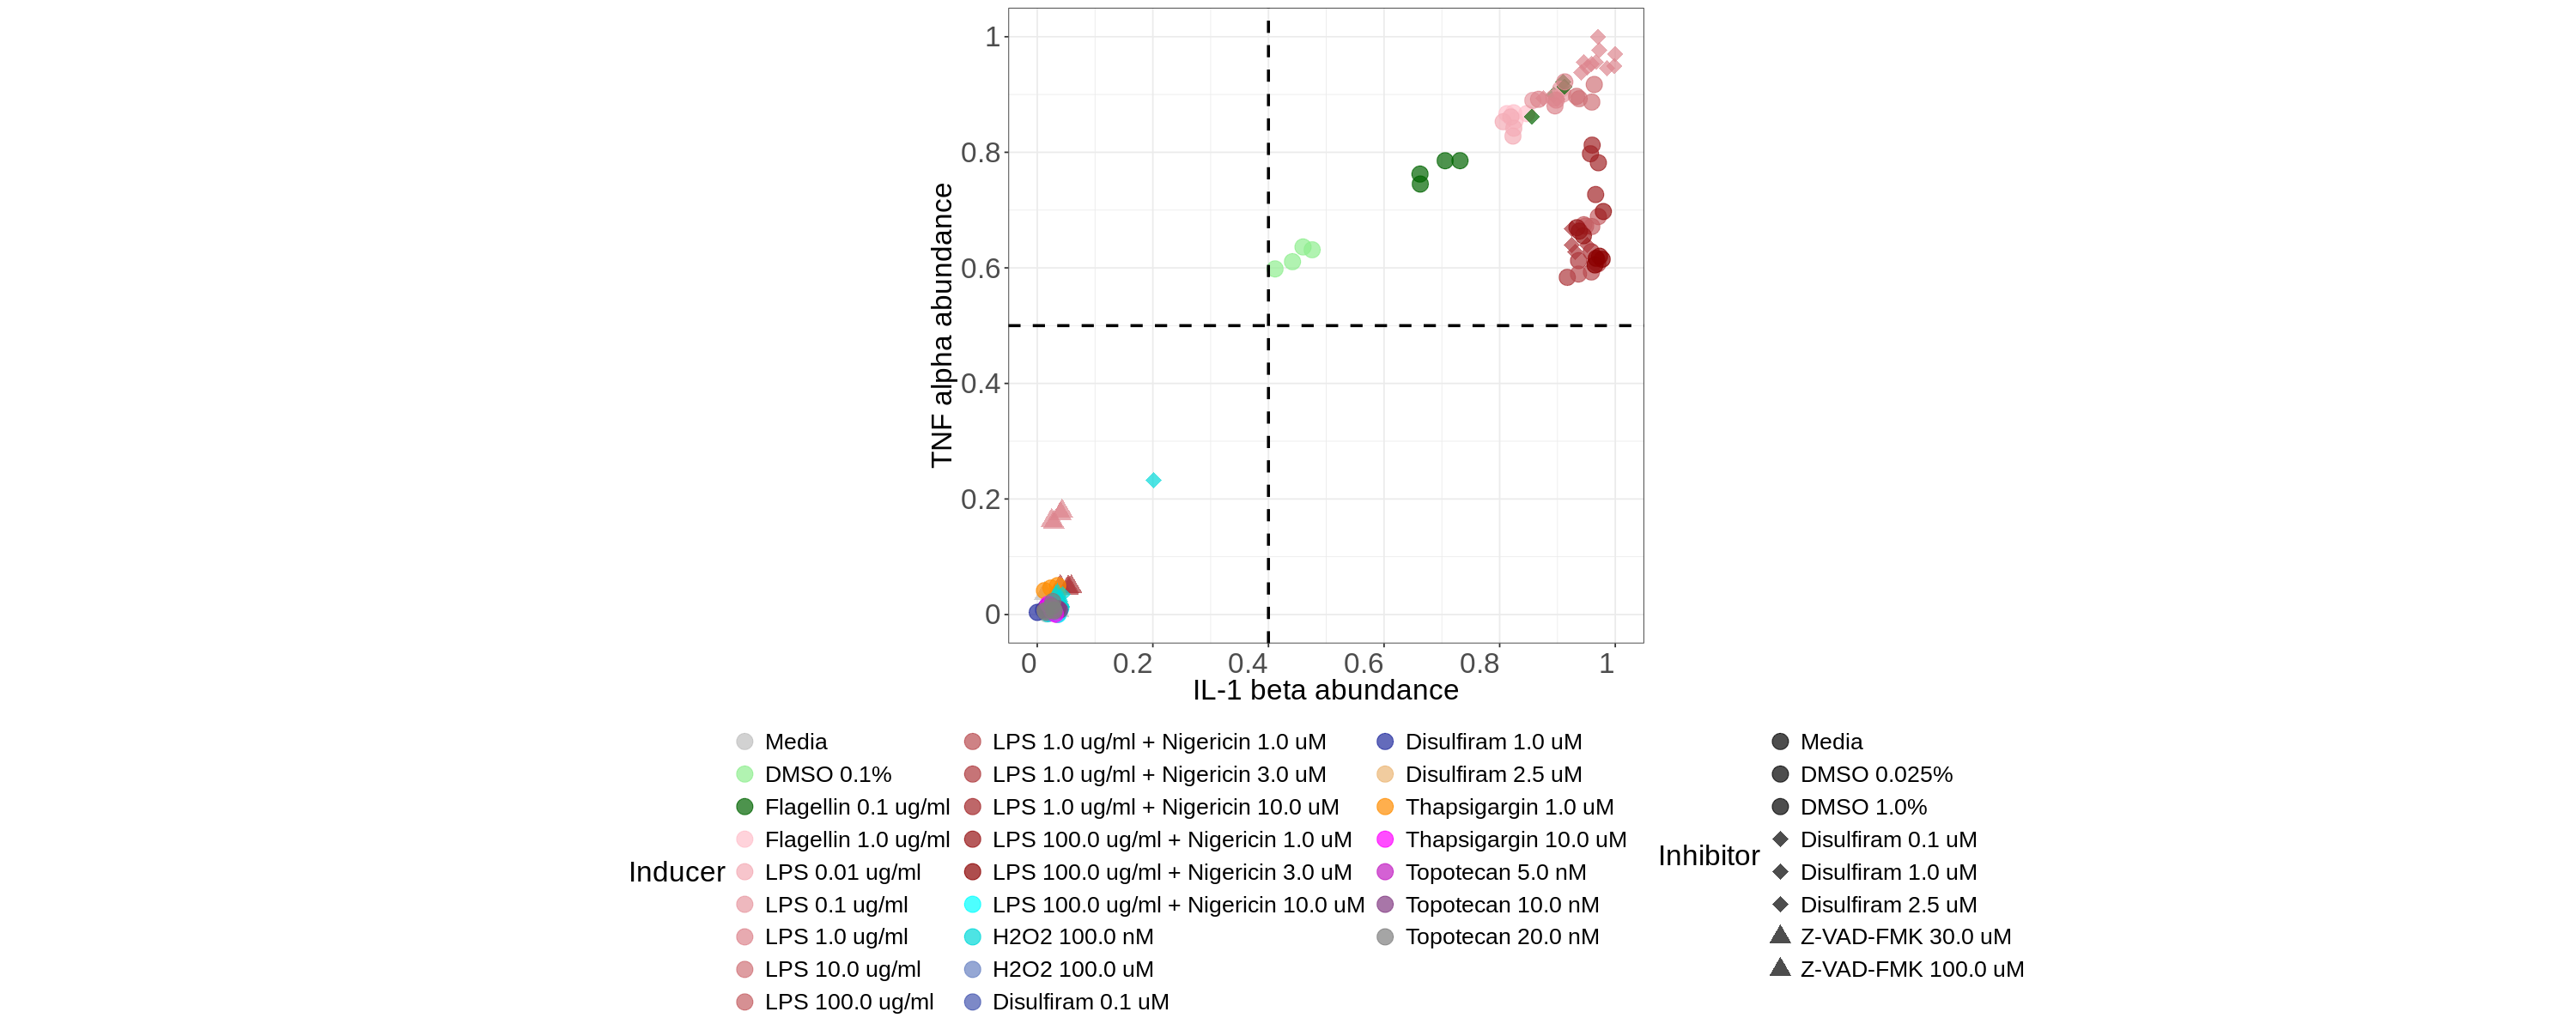

In [15]:
# set plot size
width <- 25
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
# set the pallette
# custom_pallette <- viridis::viridis_pal(option = "C")(length(unique(cytokine_values$group_treatment)))
custom_pallette = createPalette(37,  c("#ff0000", "#00ff00", "#0000ff"))
custom_pallette <- sortByHue(custom_pallette)
custom_pallette <- as.vector(t(matrix(custom_pallette, ncol=4)))

cytokine_scatter_plot2 <- (
    ggplot(
        data = cytokine_values,
        aes(
            x = `IL-1 beta [NSU]`,
            y = `TNF alpha [NSU]`,
            color = inducer,
            shape = inhibitor
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + xlab("IL-1 beta abundance")
    + ylab("TNF alpha abundance")
    + xlim(-0.1, 1.1)
    + ylim(-0.1, 1.1)
    # x scale breaks
    + scale_x_continuous(
        breaks = seq(0, 1, 0.2),
        labels = seq(0, 1, 0.2)
    )
    # y scale breaks
    + scale_y_continuous(
        breaks = seq(0, 1, 0.2),
        labels = seq(0, 1, 0.2)
    )
    # rotate x axis text
    + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))

    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
        + scale_color_manual(
        name = "Inducer",
        labels = c(
            'Media',
            'DMSO 0.1%',

            'Flagellin 0.1 ug/ml',
            'Flagellin 1.0 ug/ml',

            'LPS 0.01 ug/ml',
            'LPS 0.1 ug/ml',
            'LPS 1.0 ug/ml',
            'LPS 10.0 ug/ml',
            'LPS 100.0 ug/ml',

            'LPS 1.0 ug/ml + Nigericin 1.0 uM',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM',

            'LPS 100.0 ug/ml + Nigericin 1.0 uM',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM',

            'H2O2 100.0 nM',
            'H2O2 100.0 uM',

            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Thapsigargin 1.0 uM',
            'Thapsigargin 10.0 uM',

            'Topotecan 5.0 nM',
            'Topotecan 10.0 nM',
            'Topotecan 20.0 nM'
        ),
        values = colors)
    + scale_shape_manual(
        name = "Inhibitor",
        labels = c(
            'Media',
            'DMSO 0.025%',
            'DMSO 1.0%',

            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Z-VAD-FMK 30.0 uM',
            'Z-VAD-FMK 100.0 uM'
        ),
        values = shapes
    )
    + theme(legend.position = "bottom")
    # set the legend columns to 4
    + guides(color = guide_legend(ncol = 3))
    + guides(shape = guide_legend(ncol = 1))
    

)
    
# cytokine_scatter_plot add gates 
cytokine_scatter_plot2 <- (
    cytokine_scatter_plot2
    + geom_vline(xintercept = 0.4, linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1)
    + ggplot2::coord_fixed()
)
cytokine_scatter_plot2


## Heatmap of cytokine concentration

In [16]:
# import melted dataframes
# Figure 2A

# Load data
data_path_cytokine_values_melted <- file.path("..","..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/PBMC_all_cytokine_values_per_treatment_per_well_melted.parquet")
cytokine_values_melted <- arrow::read_parquet(data_path_cytokine_values_melted)
# filter out the treatments that are not in the list
cytokine_values_melted <- subset(cytokine_values_melted, select = -Metadata_position_x)

# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)

# convert to a dataframe
cytokine_values_melted <- as.data.frame(cytokine_values_melted)

# make a new column that is the treatment group based on the ground truth data
cytokine_values_melted$group <- ifelse(cytokine_values_melted$oneb_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cytokine_values_melted$oneb_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cytokine_values_melted$oneb_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cytokine_values_melted$group <- factor(cytokine_values_melted$group, levels = c("Control","Apoptosis", "Pyroptosis"))

# read in the anova data
anova_df_path <- file.path("..","..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/tukey_unfiltered_nomic_results.csv")
anova_df <- read.csv(anova_df_path)
# order the anova df by the cytokine column alphabetically
anova_df <- anova_df[order(anova_df$cytokine),]
# split the anova df into three dataframes
anova_df_a_c <- anova_df[which(anova_df$group == "apoptosis_healthy"),]
anova_df_p_c <- anova_df[which(anova_df$group == "healthy_pyroptosis"),]
anova_df_p_a <- anova_df[which(anova_df$group == "apoptosis_pyroptosis"),]
anova_p_value_a_c <- anova_df_a_c$X.log10.p.adj.
anova_p_value_p_c <- anova_df_p_c$X.log10.p.adj.
anova_p_value_p_a <- anova_df_p_a$X.log10.p.adj.
# get the max p value
max_p_value <- max(c(anova_p_value_a_c, anova_p_value_p_c, anova_p_value_p_a))
# get the min p value
min_p_value <- min(c(anova_p_value_a_c, anova_p_value_p_c, anova_p_value_p_a))
print(max_p_value)
print(min_p_value)


[1] 4
[1] 0


In [17]:
# drop two columns by name 
# aggregate the cytokine values across the treatments and cytokine
cytokine_values_agg <- cytokine_values_melted %>%
    group_by(cytokine,oneb_Treatment_Dose_Inhibitor_Dose, group) %>%
    summarise_all(mean)


In [18]:
length(unique(cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose))
# mutate the names of each treatment
cytokine_values_agg <- cytokine_values_agg %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Media' ~ "Media",

    ))
length(unique(cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose))


[1] 37

[1] 37

In [19]:
length(unique(cytokine_values_agg$cytokine))
# gsub out '[NSU]' from the cytokine names
cytokine_values_agg$cytokine <- gsub('\\[NSU\\]', '', cytokine_values_agg$cytokine)
length(unique(cytokine_values_agg$cytokine))
    

[1] 187

[1] 187

In [20]:
# aggregate the cytokine values across the treatments and group
groups <- cytokine_values_agg %>%
    group_by(group, oneb_Treatment_Dose_Inhibitor_Dose) %>%
    summarise_all(mean)


Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(cytokine):
“argument is not 

In [21]:
# create a matrix of the cytokine values for the clustering and heatmap
# unmelt the data 
cytokine_values_agg <- reshape2::dcast(cytokine_values_agg, oneb_Treatment_Dose_Inhibitor_Dose ~ cytokine, value.var = "cytokine_value", fun.aggregate = mean)
# make oneb_Metadata_Treatment_Dose_Inhibitor_Dose the rownames
rownames(cytokine_values_agg) <- cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose
# drop the column
cytokine_values_agg <- subset(cytokine_values_agg, select = -c(oneb_Treatment_Dose_Inhibitor_Dose))


In [22]:
# get the rownames
rownames(cytokine_values_agg)
# make the the rownames a df
rownames_df <- data.frame(rownames(cytokine_values_agg))
# merge the groups df to the rownames df
rownames_df <- merge(rownames_df, groups, by.x = "rownames.cytokine_values_agg.", by.y = "oneb_Treatment_Dose_Inhibitor_Dose")
groups <- rownames_df$group

[1] "Disulfiram 0.1 uM - DMSO 0.025%"                       
 [2] "Disulfiram 1.0 uM - DMSO 0.025%"                       
 [3] "Disulfiram 2.5 uM - DMSO 0.025%"                       
 [4] "DMSO 0.1% - DMSO 0.025%"                               
 [5] "DMSO 0.1% - DMSO 1.0%"                                 
 [6] "DMSO 0.1% - Z-VAD-FMK 100.0 uM"                        
 [7] "DMSO 0.1% - Z-VAD-FMK 30.0 uM"                         
 [8] "Flagellin 0.1 ug/ml - DMSO 0.025%"                     
 [9] "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM"               
[10] "Flagellin 1.0 ug/ml - DMSO 0.025%"                     
[11] "H2O2 100.0 nM - DMSO 0.025%"                           
[12] "H2O2 100.0 uM - Disulfiram 1.0 uM"                     
[13] "H2O2 100.0 uM - DMSO 0.025%"                           
[14] "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM"                    
[15] "LPS 0.01 ug/ml - DMSO 0.025%"                          
[16] "LPS 0.1 ug/ml - DMSO 0.025%"                           
[17] "LPS 1.0 ug/ml - DMSO 0.025%"                           
[18] "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"        
[19] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM" 
[20] "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"       
[21] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM"
[22] "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"        
[23] "LPS 10.0 ug/ml - Disulfiram 0.1 uM"                    
[24] "LPS 10.0 ug/ml - Disulfiram 1.0 uM"                    
[25] "LPS 10.0 ug/ml - Disulfiram 2.5 uM"                    
[26] "LPS 10.0 ug/ml - DMSO 0.025%"                          
[27] "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM"                   
[28] "LPS 100.0 ug/ml - DMSO 0.025%"                         
[29] "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"      
[30] "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"     
[31] "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"      
[32] "Media"                                                 
[33] "Thapsigargin 1.0 uM - DMSO 0.025%"                     
[34] "Thapsigargin 10.0 uM - DMSO 0.025%"                    
[35] "Topotecan 10.0 nM - DMSO 0.025%"                       
[36] "Topotecan 20.0 nM - DMSO 0.025%"                       
[37] "Topotecan 5.0 nM - DMSO 0.025%"

In [23]:
row_dend <- as.dendrogram(hclust(dist(cytokine_values_agg)))
col_dend <- as.dendrogram(hclust(dist(t(cytokine_values_agg))))

In [24]:
# remove '[NSU]' from the column names
colnames(cytokine_values_agg) <- gsub("\\[NSU\\]", "", colnames(cytokine_values_agg))

In [25]:
cytokine_values_agg <- as.matrix(cytokine_values_agg)


In [26]:
# set annotations
row_ha_1 <- rowAnnotation(
    Control_Apoptosis = anova_p_value_a_c,
    show_legend = TRUE,
    annotation_name_side = "top",
    # rotate the title
    annotation_legend_param = list(
                title = "Control vs. Apoptosis\n -log10(adj, p-value)", at = c(min_p_value, max_p_value), 
                title_position = "topcenter", 
                title_gp = gpar(fontsize = 16), 
                labels_gp = gpar(fontsize = 16),
                direction = "horizontal",
                # padding = unit(c(10, 10, 5, 5), "mm"),
                legend_width = unit(10, "cm"),
                legend_height = unit(10, "cm")
                ),
    annotation_name_gp = gpar(fontsize = 16),
    # set color bar for r2 continuous value with brewer palette
    col = list(Control_Apoptosis = colorRamp2(c(0, 4), spectral_palette <- c(
        # white
        "#FFFFFF",
        # dark blue
        brewer.pal(3, "Dark2")[1]
    )))
)    

row_ha_2 <- rowAnnotation(
    Control_Pyroptosis = anova_p_value_p_c,
    show_legend = TRUE,
    annotation_name_side = "top",
    # rotate the title
    annotation_legend_param = list(
                title = "Control vs. Pyroptosis\n -log10(adj, p-value)", at = c(min_p_value, max_p_value), 
                title_position = "topcenter", 
                title_gp = gpar(fontsize = 16), 
                labels_gp = gpar(fontsize = 16),
                direction = "horizontal",
                padding = unit(c(10, 10, 5, 5), "cm"),
                legend_width = unit(10, "cm"),
                legend_height = unit(10, "cm")
                ),
    annotation_name_gp = gpar(fontsize = 16),
    # set color bar for r2 continuous value with brewer palette
    col = list(Control_Pyroptosis = colorRamp2(c(0, 4), spectral_palette <- c(
        # white
        "#FFFFFF",
        # dark blue
        brewer.pal(3, "Dark2")[3]
    )))
)

row_ha_3 <- rowAnnotation(
    Apoptosis_Pyroptosis = anova_p_value_p_a,
    show_legend = TRUE,
    annotation_name_side = "top",
    # rotate the title
    annotation_legend_param = list(
                title = "Apoptosis vs. Pyroptosis\n -log10(adj, p-value)", at = c(min_p_value, max_p_value), 
                title_position = "topcenter", 
                title_gp = gpar(fontsize = 16), 
                labels_gp = gpar(fontsize = 16),
                direction = "horizontal",
                # padding = unit(c(10, 10, 5, 5), "cm"),
                legend_width = unit(10, "cm"),
                legend_height = unit(10, "cm")
                ),
    annotation_name_gp = gpar(fontsize = 16),
    # set color bar for r2 continuous value with brewer palette
    col = list(Apoptosis_Pyroptosis = colorRamp2(c(0, 4), spectral_palette <- c(
        # white
        "#FFFFFF",
        # dark blue
        brewer.pal(3, "Dark2")[2]
    )))
)

cell_death_annotation <- HeatmapAnnotation(
    CellDeath = groups,
    show_legend = TRUE,
    annotation_name_side = "left",
    # rotate the title
    annotation_legend_param = list(
        labels_gp = gpar(fontsize = 16, angle = 0),
        title_position = "topcenter",
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5)
    ),
    annotation_name_gp = gpar(fontsize = 16),
    # set color bar for r2 continuous value with brewer palette
    col = list(
            CellDeath = c(
            "Control" = brewer.pal(8, "Dark2")[1],
            "Apoptosis" = brewer.pal(8, "Dark2")[3],
            "Pyroptosis" = brewer.pal(3, "Dark2")[2]
            
        )
    )

)    


png 
  2

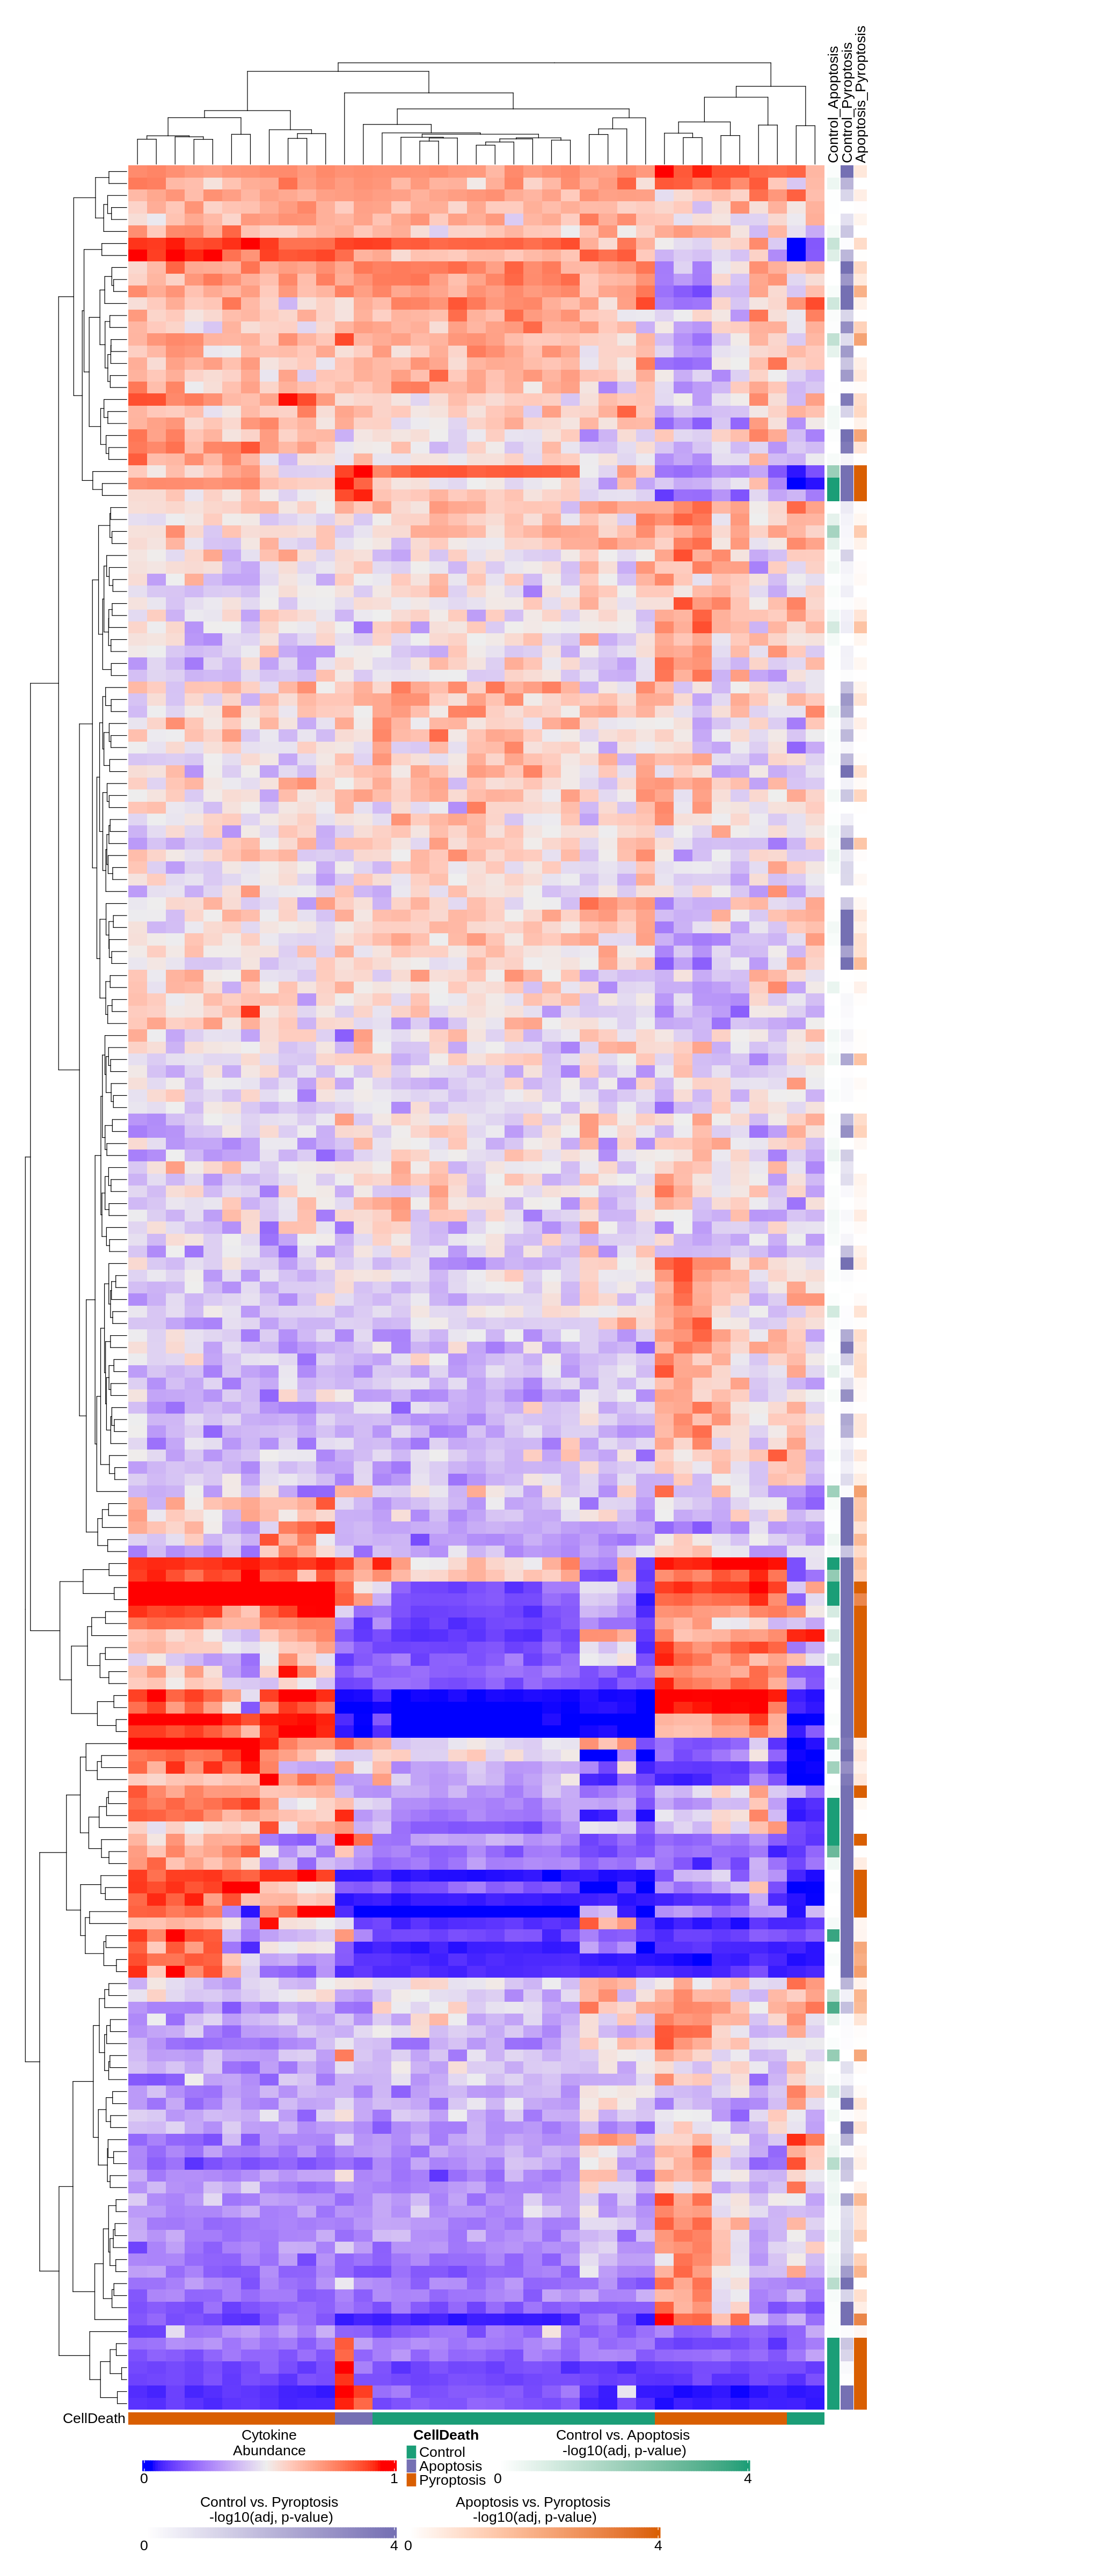

In [27]:
# set plot size 
width <- 17
height <- 40
options(repr.plot.width=width, repr.plot.height=height)
heatmap_plot_all <- (
  Heatmap(
  t(cytokine_values_agg),
  cluster_rows = TRUE,    # Cluster rows
  cluster_columns = TRUE, # Cluster columns
  show_row_names = FALSE,  # Show row names
  show_column_names = FALSE, # Show column names
  column_names_gp = gpar(fontsize = 10), # Column name label formatting
  row_names_gp = gpar(fontsize = 12),    # Row name label formatting
  right_annotation = c(row_ha_1, row_ha_2, row_ha_3),
  bottom_annotation = cell_death_annotation,
   heatmap_legend_param = list(
                title = "Cytokine\nAbundance", at = c(0, 1), 
                title_position = "topcenter", 
                title_gp = gpar(fontsize = 16), 
                labels_gp = gpar(fontsize = 16),
                direction = "horizontal",
                # padding = unit(c(10, 10, 5, 5), "mm"),
                legend_width = unit(10, "cm"),
                legend_height = unit(10, "cm")
                ),
  # make the tiles rectangular
#   rect_gp = gpar(col = NA),
  column_dend_height = unit(4, "cm"), 
  row_dend_width = unit(4, "cm")
    )
)

heatmap_plot_all <- draw(
    heatmap_plot_all, 
    heatmap_legend_side = "bottom", 
#     # annotation_legend_side = "right",
#     # change locaiton of the legend
    merge_legend = TRUE,
    padding = unit(c(1, 1, 1, 9), "cm"),
)

# make a dir if it does not exist
if (!dir.exists(file.path("..","figures"))){
    dir.create(file.path("..","figures"))
}
png(file.path("..","figures","all_cytokines_heatmap.png"), width = width, height = height, units = "in", res = 600)
heatmap_plot_all
dev.off()
heatmap_plot_all


rastergrob[GRID.rastergrob.1187] 

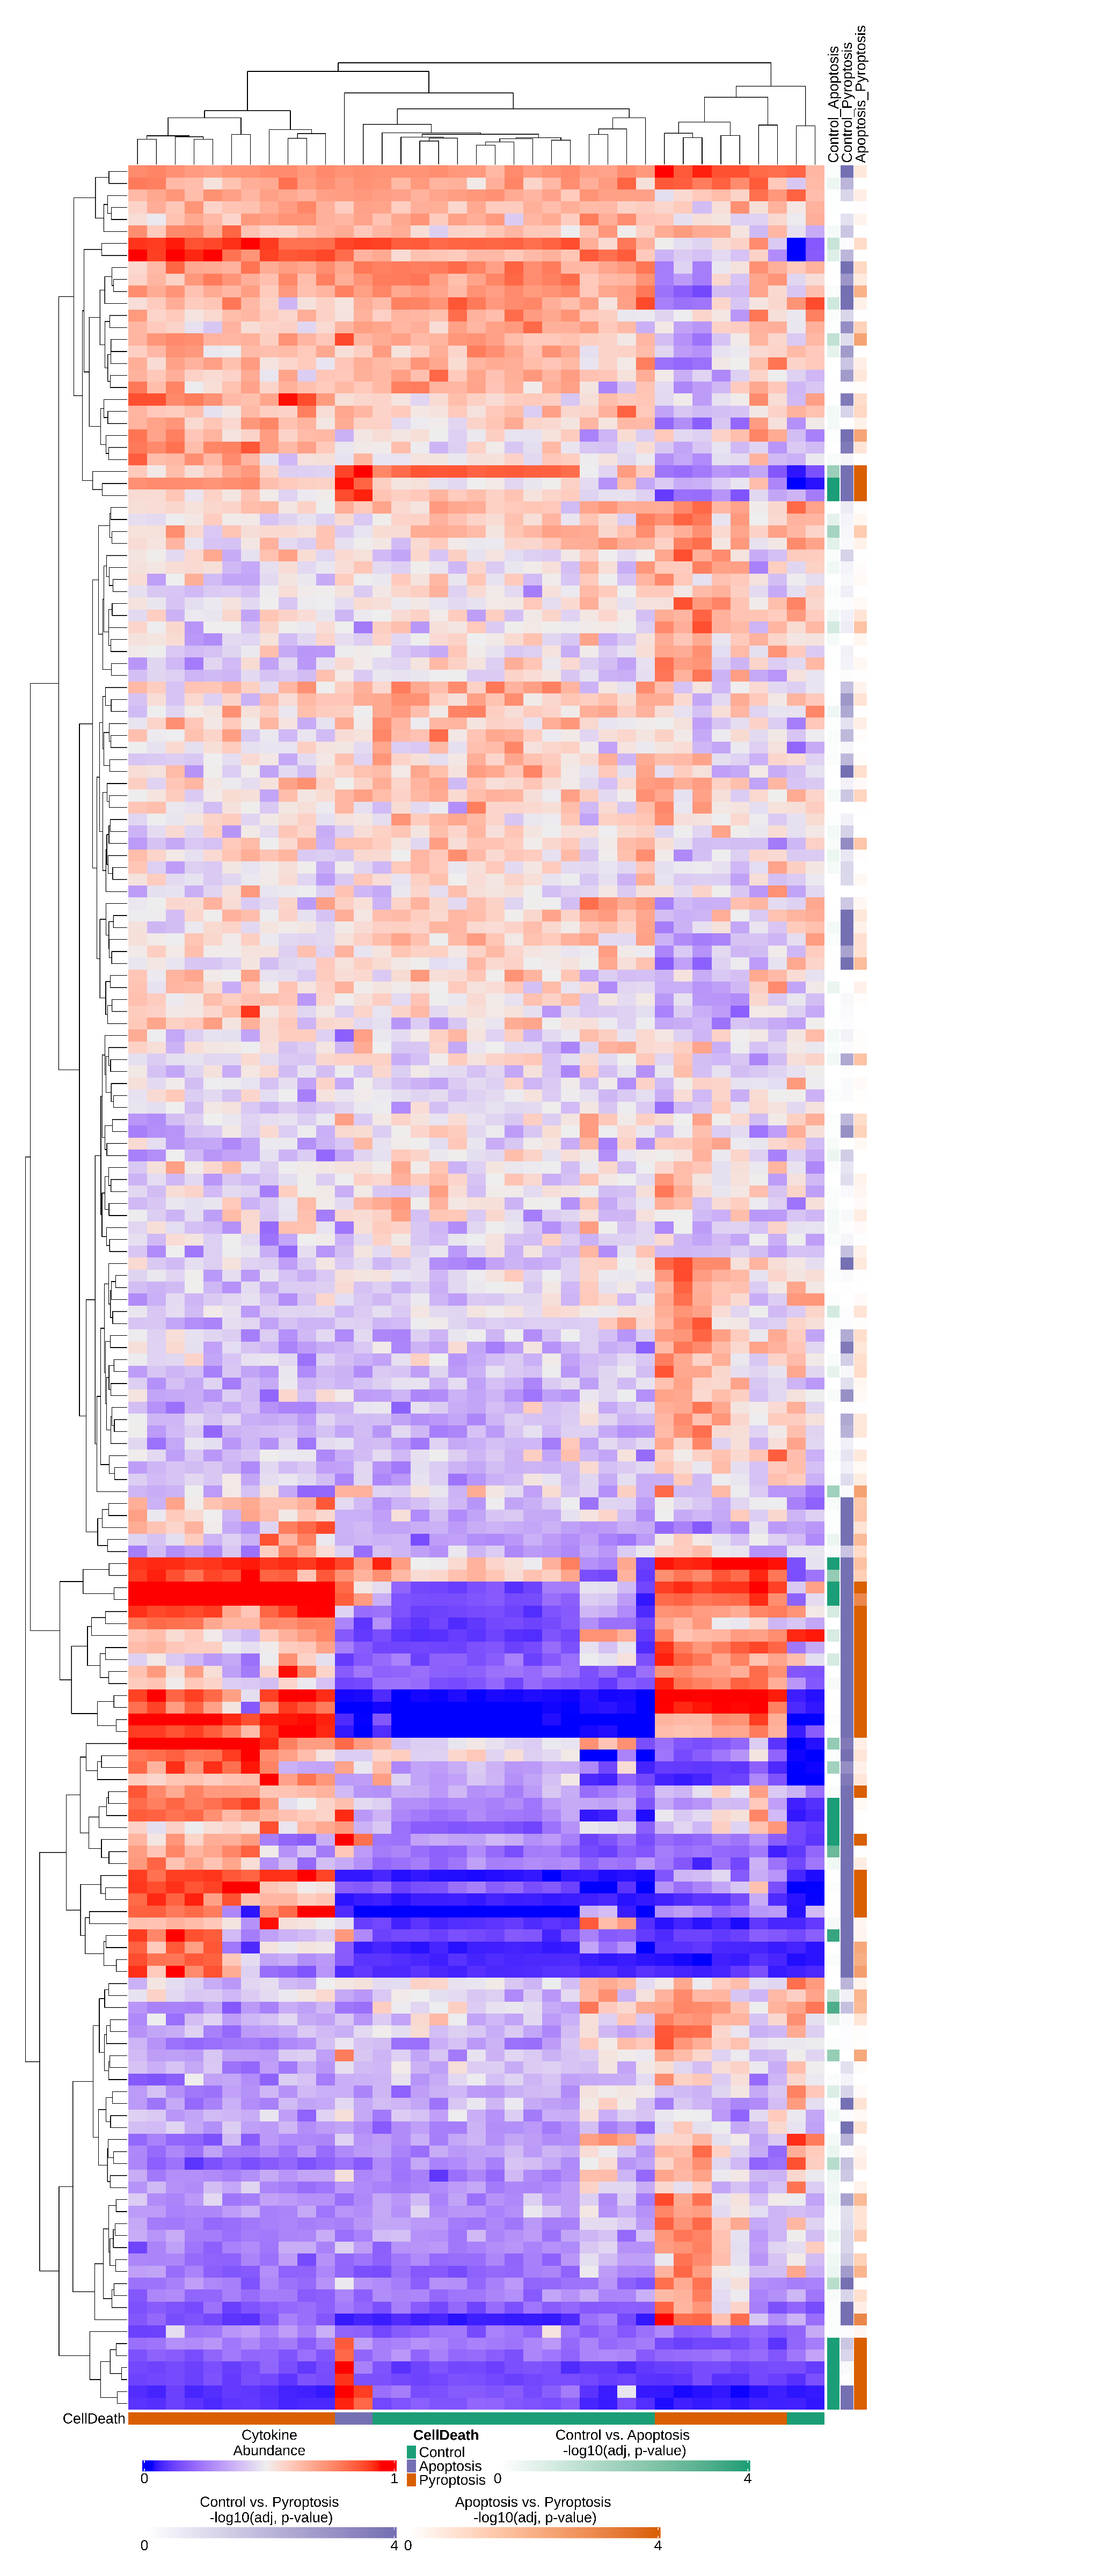

In [28]:
# load in the png to a grob object
heatmap_grob <- png::readPNG(file.path("..","figures","all_cytokines_heatmap.png"))
# convert the grob object to a raster grob
heatmap_cytokines <- rasterGrob(heatmap_grob, interpolate = TRUE)

# heatmap_anova_cytokines
heatmap_cytokines
# # Defien the heatmap as a ggplot heatmap for figure curation
# set plot size
# set plot size 
width <- 17
height <- 40
options(repr.plot.width=width, repr.plot.height=height, units = "in")
heatmap_cytokines <- as.ggplot(heatmap_cytokines) 
heatmap_cytokines


## UMAP Plots

In [29]:
# read in the UMAP results
umap_results_path <- file.path("..","..","..","2.Nomic_nELISA_Analysis/1.umap/PBMC/results/nELISA_plate_430420_umap_PBMC.csv")
# read in the data
umap_results <- read.csv(umap_results_path, header = TRUE, sep = ",")
length(unique(umap_results$oneb_Treatment_Dose_Inhibitor_Dose))

[1] 40

In [30]:
# convert to a dataframe
umap_results <- as.data.frame(umap_results)

# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%
umap_results$oneb_Treatment_Dose_Inhibitor_Dose <- ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.0_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", umap_results$oneb_Treatment_Dose_Inhibitor_Dose)
umap_results$oneb_Treatment_Dose_Inhibitor_Dose <- ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", "Flagellin_1.000_ug_per_ml_DMSO_0.025_%", umap_results$oneb_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
umap_results$group <- ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(umap_results$oneb_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
umap_results$group <- factor(umap_results$group, levels = c("Control","Apoptosis", "Pyroptosis"))

In [31]:
# mutate the names of each treatment

umap_results <- umap_results %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media ctr 0.0 0",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_0.0_0' ~ "Media ctr 0.0 0"
    ))
    # replace Media ctr 0.0 0 with Media
umap_results$oneb_Treatment_Dose_Inhibitor_Dose <- gsub("Media ctr 0.0 0", "Media", umap_results$oneb_Treatment_Dose_Inhibitor_Dose)
umap_results <- umap_results %>%
    separate(oneb_Treatment_Dose_Inhibitor_Dose, c("inducer", "inhibitor"), sep = " - ", remove = FALSE)
head(umap_results)
umap_results$inhibitor <- ifelse(is.na(umap_results$inhibitor), "Media", umap_results$inhibitor)
unique(umap_results$inhibitor)

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 6 rows [149, 150, 151,
152, 153, 154].”


,plate_name,plate_barcode,position_x,cell_type,incubation.inducer,inhibitor_concentration_value,inhibitor_concentration_unit,inhibitor_concentration,inducer1,inducer1_concentration_value,⋯,Dose,oneb_Treatment_Dose_Inhibitor_Dose,inducer,inhibitor,twob_Treatment_Dose_Inhibitor_Dose,threeb_Treatment_Dose_Inhibitor_Dose,fourb_Treatment_Dose_Inhibitor_Dose,umap_1,umap_2,group
,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>
1,70117_20230210MM1_P1,430420,B06,PBMC,6_h,0.025,%,0.03,DMSO,0.1,⋯,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,-3.847429,14.16169,Control
2,70117_20230210MM1_P1,430420,C06,PBMC,6_h,0.025,%,0.03,DMSO,0.1,⋯,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,-3.159999,17.53089,Control
3,70117_20230210MM1_P1,430420,I06,PBMC,6_h,0.025,%,0.03,DMSO,0.1,⋯,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,-4.438748,15.74924,Control
4,70117_20230210MM1_P1,430420,J06,PBMC,6_h,0.025,%,0.03,DMSO,0.1,⋯,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,-6.070036,15.31512,Control
5,70117_20230210MM1_P1,430420,B07,PBMC,6_h,0.025,%,0.03,DMSO,0.1,⋯,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,-3.539103,16.60268,Control
6,70117_20230210MM1_P1,430420,C07,PBMC,6_h,0.025,%,0.03,DMSO,0.1,⋯,0.100_%,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,-2.486607,14.76610,Control


[1] "DMSO 0.025%"        "DMSO 1.0%"          "Z-VAD-FMK 100.0 uM"
[4] "Z-VAD-FMK 30.0 uM"  "Disulfiram 1.0 uM"  "Disulfiram 0.1 uM" 
[7] "Disulfiram 2.5 uM"  "Media"

In [32]:



# make the group_treatment column a factor
umap_results$inducer <- factor(
    umap_results$inducer,
    levels = c(
        'Media',
        'DMSO 0.1%',

        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',

        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',

        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',

        'LPS 100.0 ug/ml + Nigericin 1.0 uM',
        'LPS 100.0 ug/ml + Nigericin 3.0 uM',
        'LPS 100.0 ug/ml + Nigericin 10.0 uM',

        'H2O2 100.0 nM',
        'H2O2 100.0 uM',

        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',

        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM',

        'Topotecan 5.0 nM',
        'Topotecan 10.0 nM',
        'Topotecan 20.0 nM'
    )
)

# make the group_treatment column a factor
umap_results$inhibitor <- factor(
    umap_results$inhibitor,
    levels = c(
        'Media',
        'DMSO 0.025%',
        'DMSO 1.0%',

        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',

        'Z-VAD-FMK 30.0 uM',
        'Z-VAD-FMK 100.0 uM'
    )
)

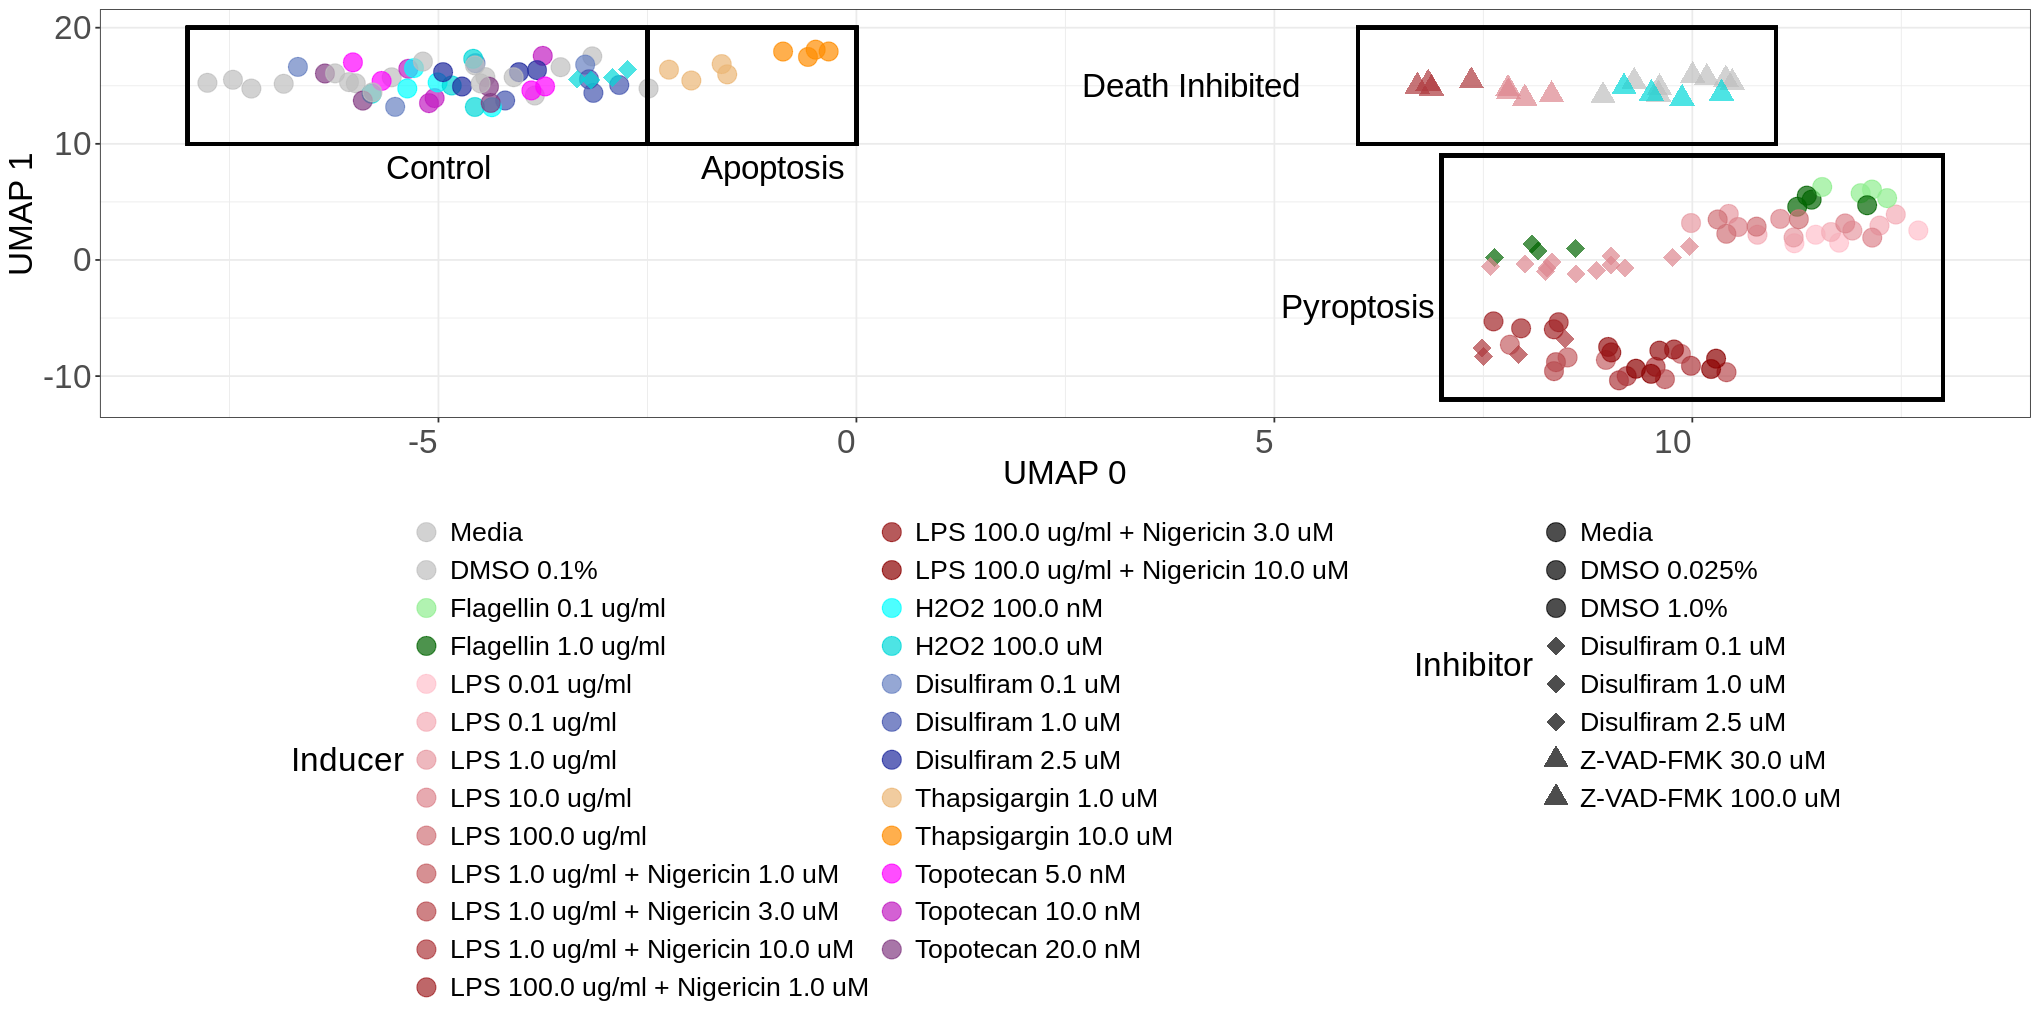

In [33]:
# set plot size
width <- 17
height <- 8.5
options(repr.plot.width=width, repr.plot.height=height)

UMAP_plot <- (
    ggplot(
        data = umap_results,
        aes(
            x = umap_1,
            y = umap_2,
            color = inducer,
            shape = inhibitor
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + xlab("UMAP 0")
    + ylab("UMAP 1")
    # rotate x axis text
    + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))

    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Inducer",
        labels = c(
            'Media',
            'DMSO 0.1%',

            'Flagellin 0.1 ug/ml',
            'Flagellin 1.0 ug/ml',

            'LPS 0.01 ug/ml',
            'LPS 0.1 ug/ml',
            'LPS 1.0 ug/ml',
            'LPS 10.0 ug/ml',
            'LPS 100.0 ug/ml',

            'LPS 1.0 ug/ml + Nigericin 1.0 uM',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM',

            'LPS 100.0 ug/ml + Nigericin 1.0 uM',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM',

            'H2O2 100.0 nM',
            'H2O2 100.0 uM',

            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Thapsigargin 1.0 uM',
            'Thapsigargin 10.0 uM',

            'Topotecan 5.0 nM',
            'Topotecan 10.0 nM',
            'Topotecan 20.0 nM'
        ),
        values = colors)
    + scale_shape_manual(
        name = "Inhibitor",
        labels = c(
            'Media',
            'DMSO 0.025%',
            'DMSO 1.0%',

            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Z-VAD-FMK 30.0 uM',
            'Z-VAD-FMK 100.0 uM'
        ),
        values = shapes
    )
    + theme(legend.position = "bottom")
    # set the legend columns to 4
    + guides(color = guide_legend(ncol = 2))
    + guides(shape = guide_legend(ncol = 1))
    
    + theme(legend.position = "bottom")
    # set the legend columns to 2
    # add space between legend columns
    + theme(legend.spacing.x = unit(1, 'cm'))
)



#add box around points 
UMAP_plot <- (
    UMAP_plot
    + geom_rect(
        aes(
            xmin = -8, xmax = -2.5, ymin = 10, ymax = 20
            ), 
            fill = NA, 
            color = "black", 
            size = 1 
        ) 
    + annotate( geom = "text", x = -5, y = 8, label = "Control", size = 7 )

    + geom_rect(
        aes(
            xmin = -2.5, xmax = 0, ymin = 10, ymax = 20 
            ), 
            fill = NA, 
            color = "black", 
            size = 1 
            )
    + annotate( geom = "text", x = -1, y = 8, label = "Apoptosis", size = 7 )

    + geom_rect(
        aes(
            xmin = 7, xmax = 13, ymin = -12, ymax = 9
            ), 
            fill = NA, 
            color = "black", 
            size = 1 
            )
    + annotate( geom = "text", x = 6, y = -4, label = "Pyroptosis", size = 7 )

    + geom_rect(
        aes(
            xmin = 6, xmax = 11, ymin = 10, ymax = 20 
            ), 
            fill = NA, 
            color = "black", 
            size = 1 
            )
    + annotate( geom = "text", x = 4, y = 15, label = "Death Inhibited", size = 7 )
)

 UMAP_plot 



## Patch the plots  together 

In [34]:
# show the plots first as assigned names
# set plot size 
options(repr.plot.width=5, repr.plot.height=5)


In [35]:

# add padding to scatter plot
cytokine_scatter_plot1 <- cytokine_scatter_plot1 + theme(plot.margin = unit(c(1,1,1,1), "cm"))
cytokine_scatter_plot2 <- cytokine_scatter_plot2 + theme(plot.margin = unit(c(1,1,1,1), "cm"))

# remove the legend
cytokine_scatter_plot1 <- cytokine_scatter_plot1 + theme(legend.position = "none")
cytokine_scatter_plot2 <- cytokine_scatter_plot2 + theme(legend.position = "none")
# add padding to the umap
UMAP_plot <- UMAP_plot + theme(plot.margin = unit(c(1,0,0,0), "cm"))
# heatmap_cytokines
# set plot size
width <- 5
height <- 5
options(repr.plot.width=width, repr.plot.height=height, units = "cm")
cytokine_scatter_plot1 <- as.ggplot(cytokine_scatter_plot1)
cytokine_scatter_plot2 <- as.ggplot(cytokine_scatter_plot2)
UMAP_plot <- as.ggplot(UMAP_plot)



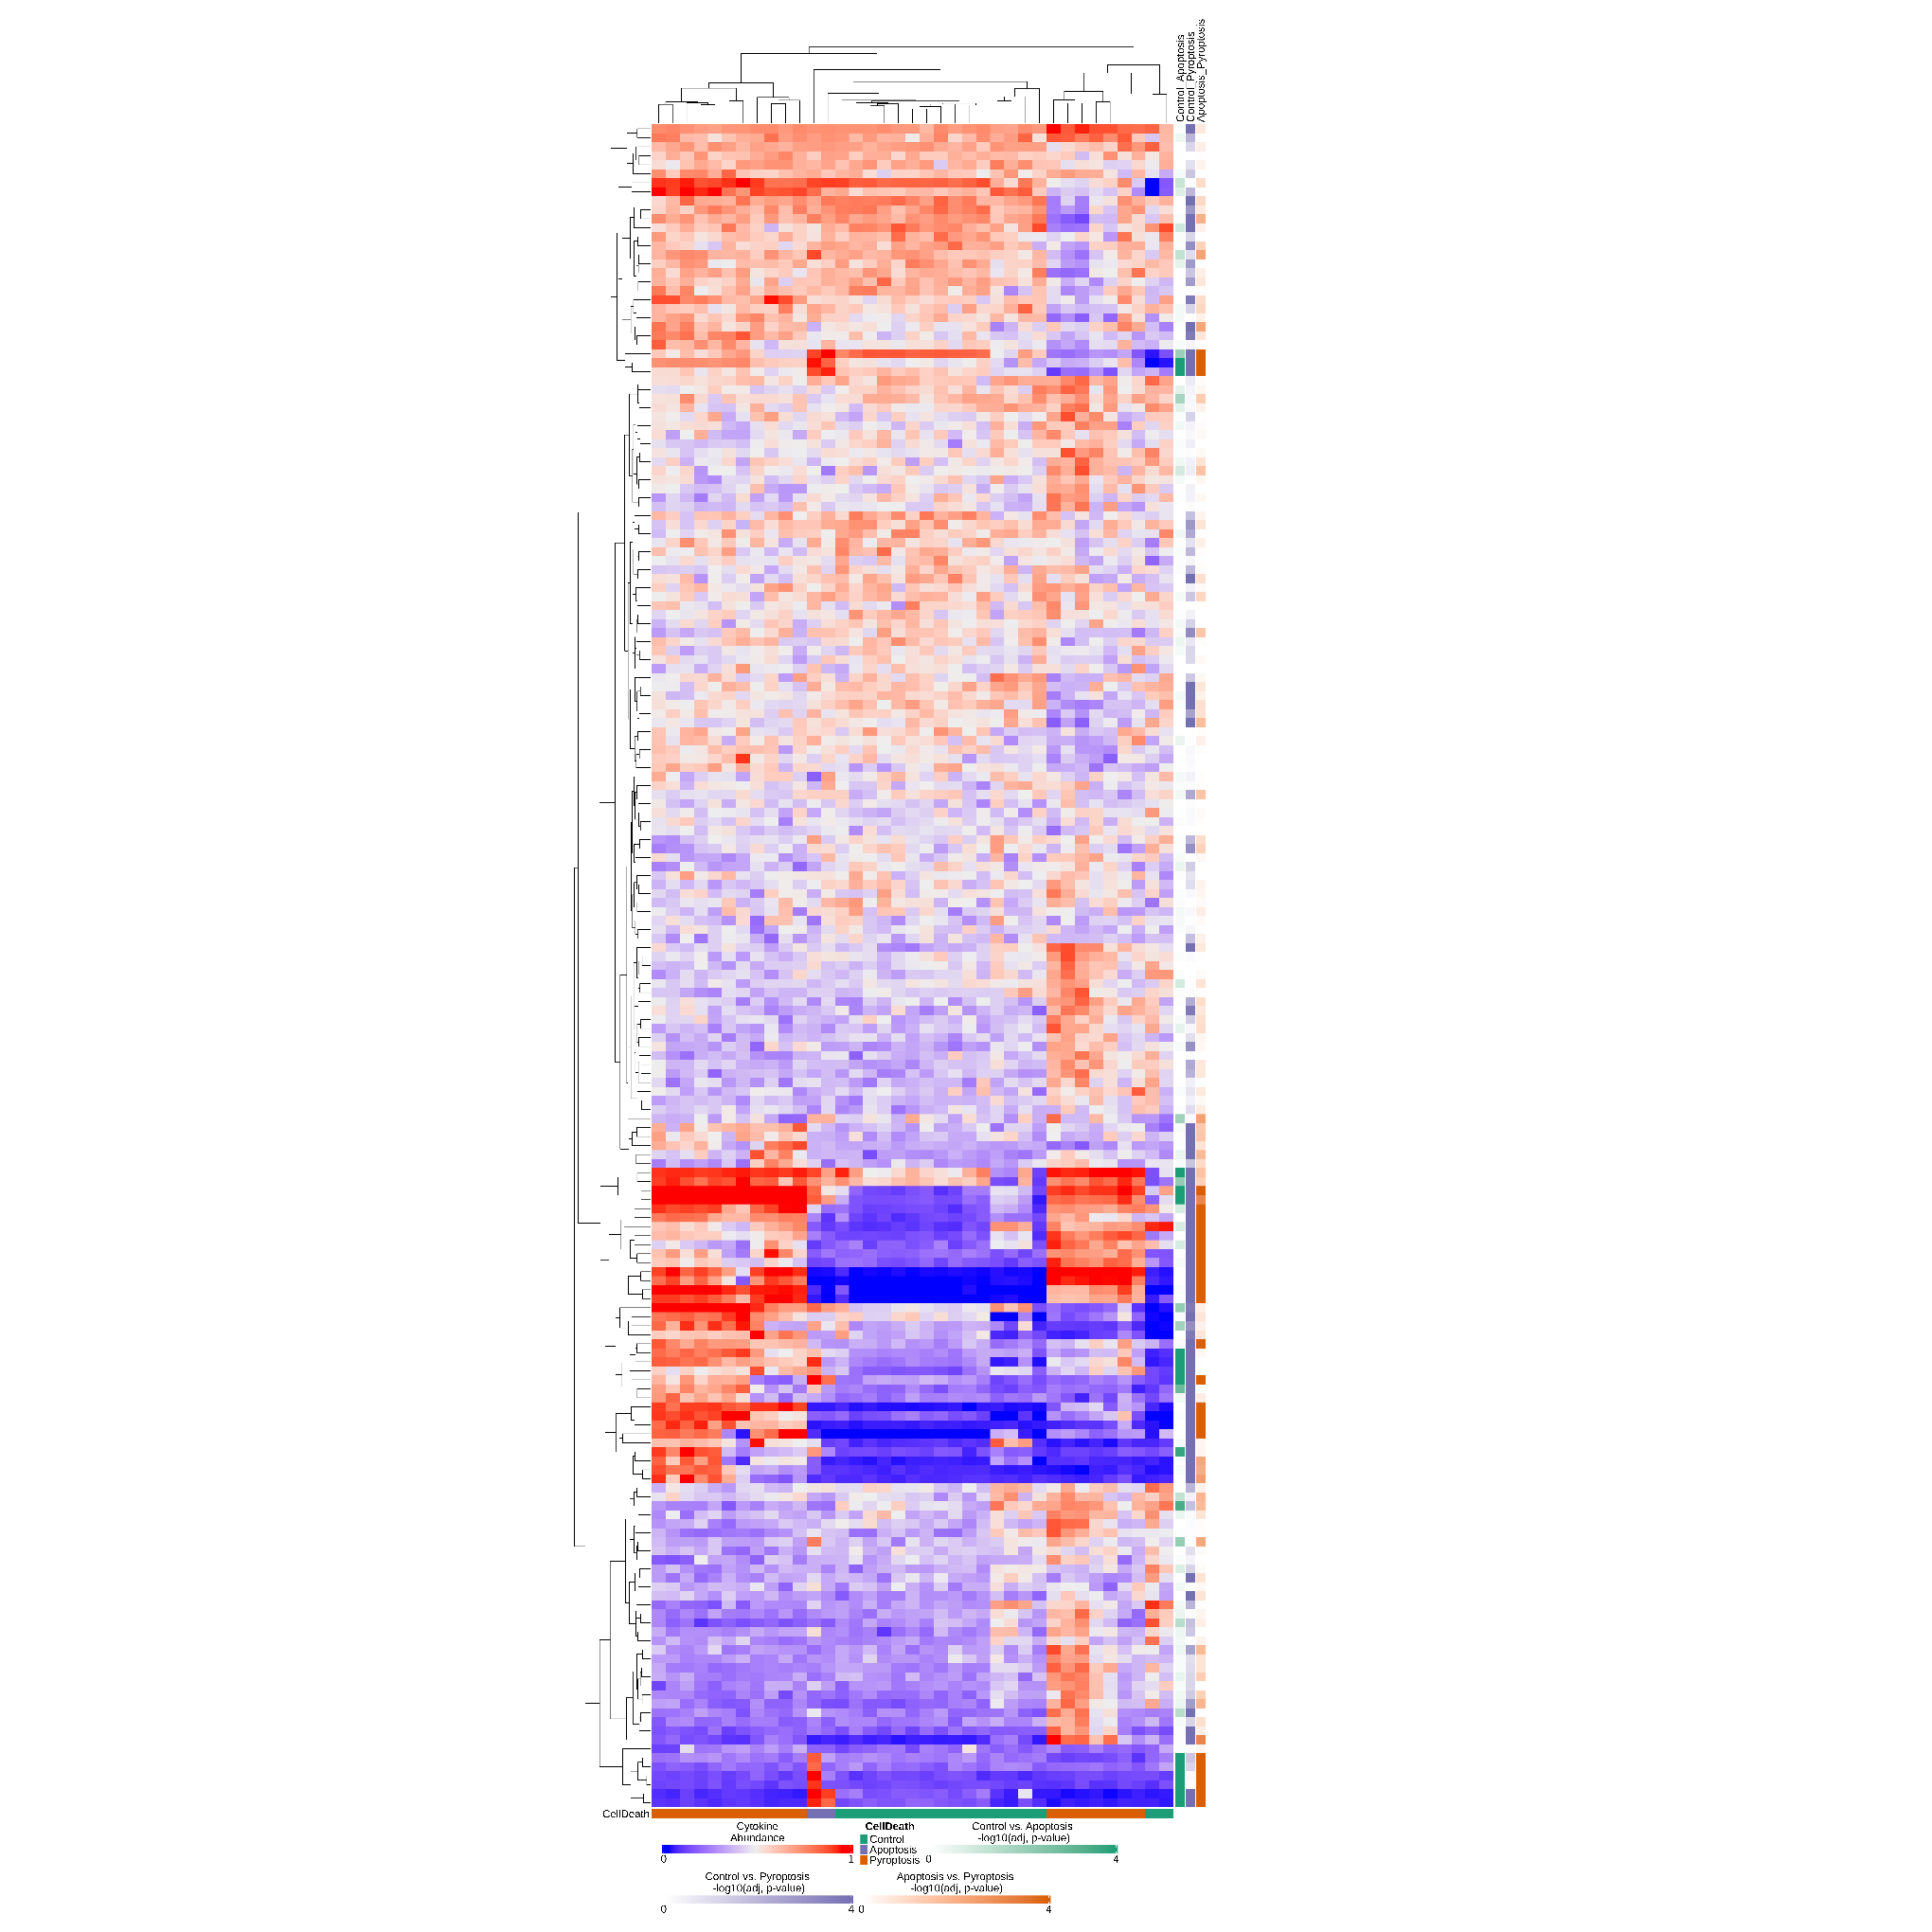

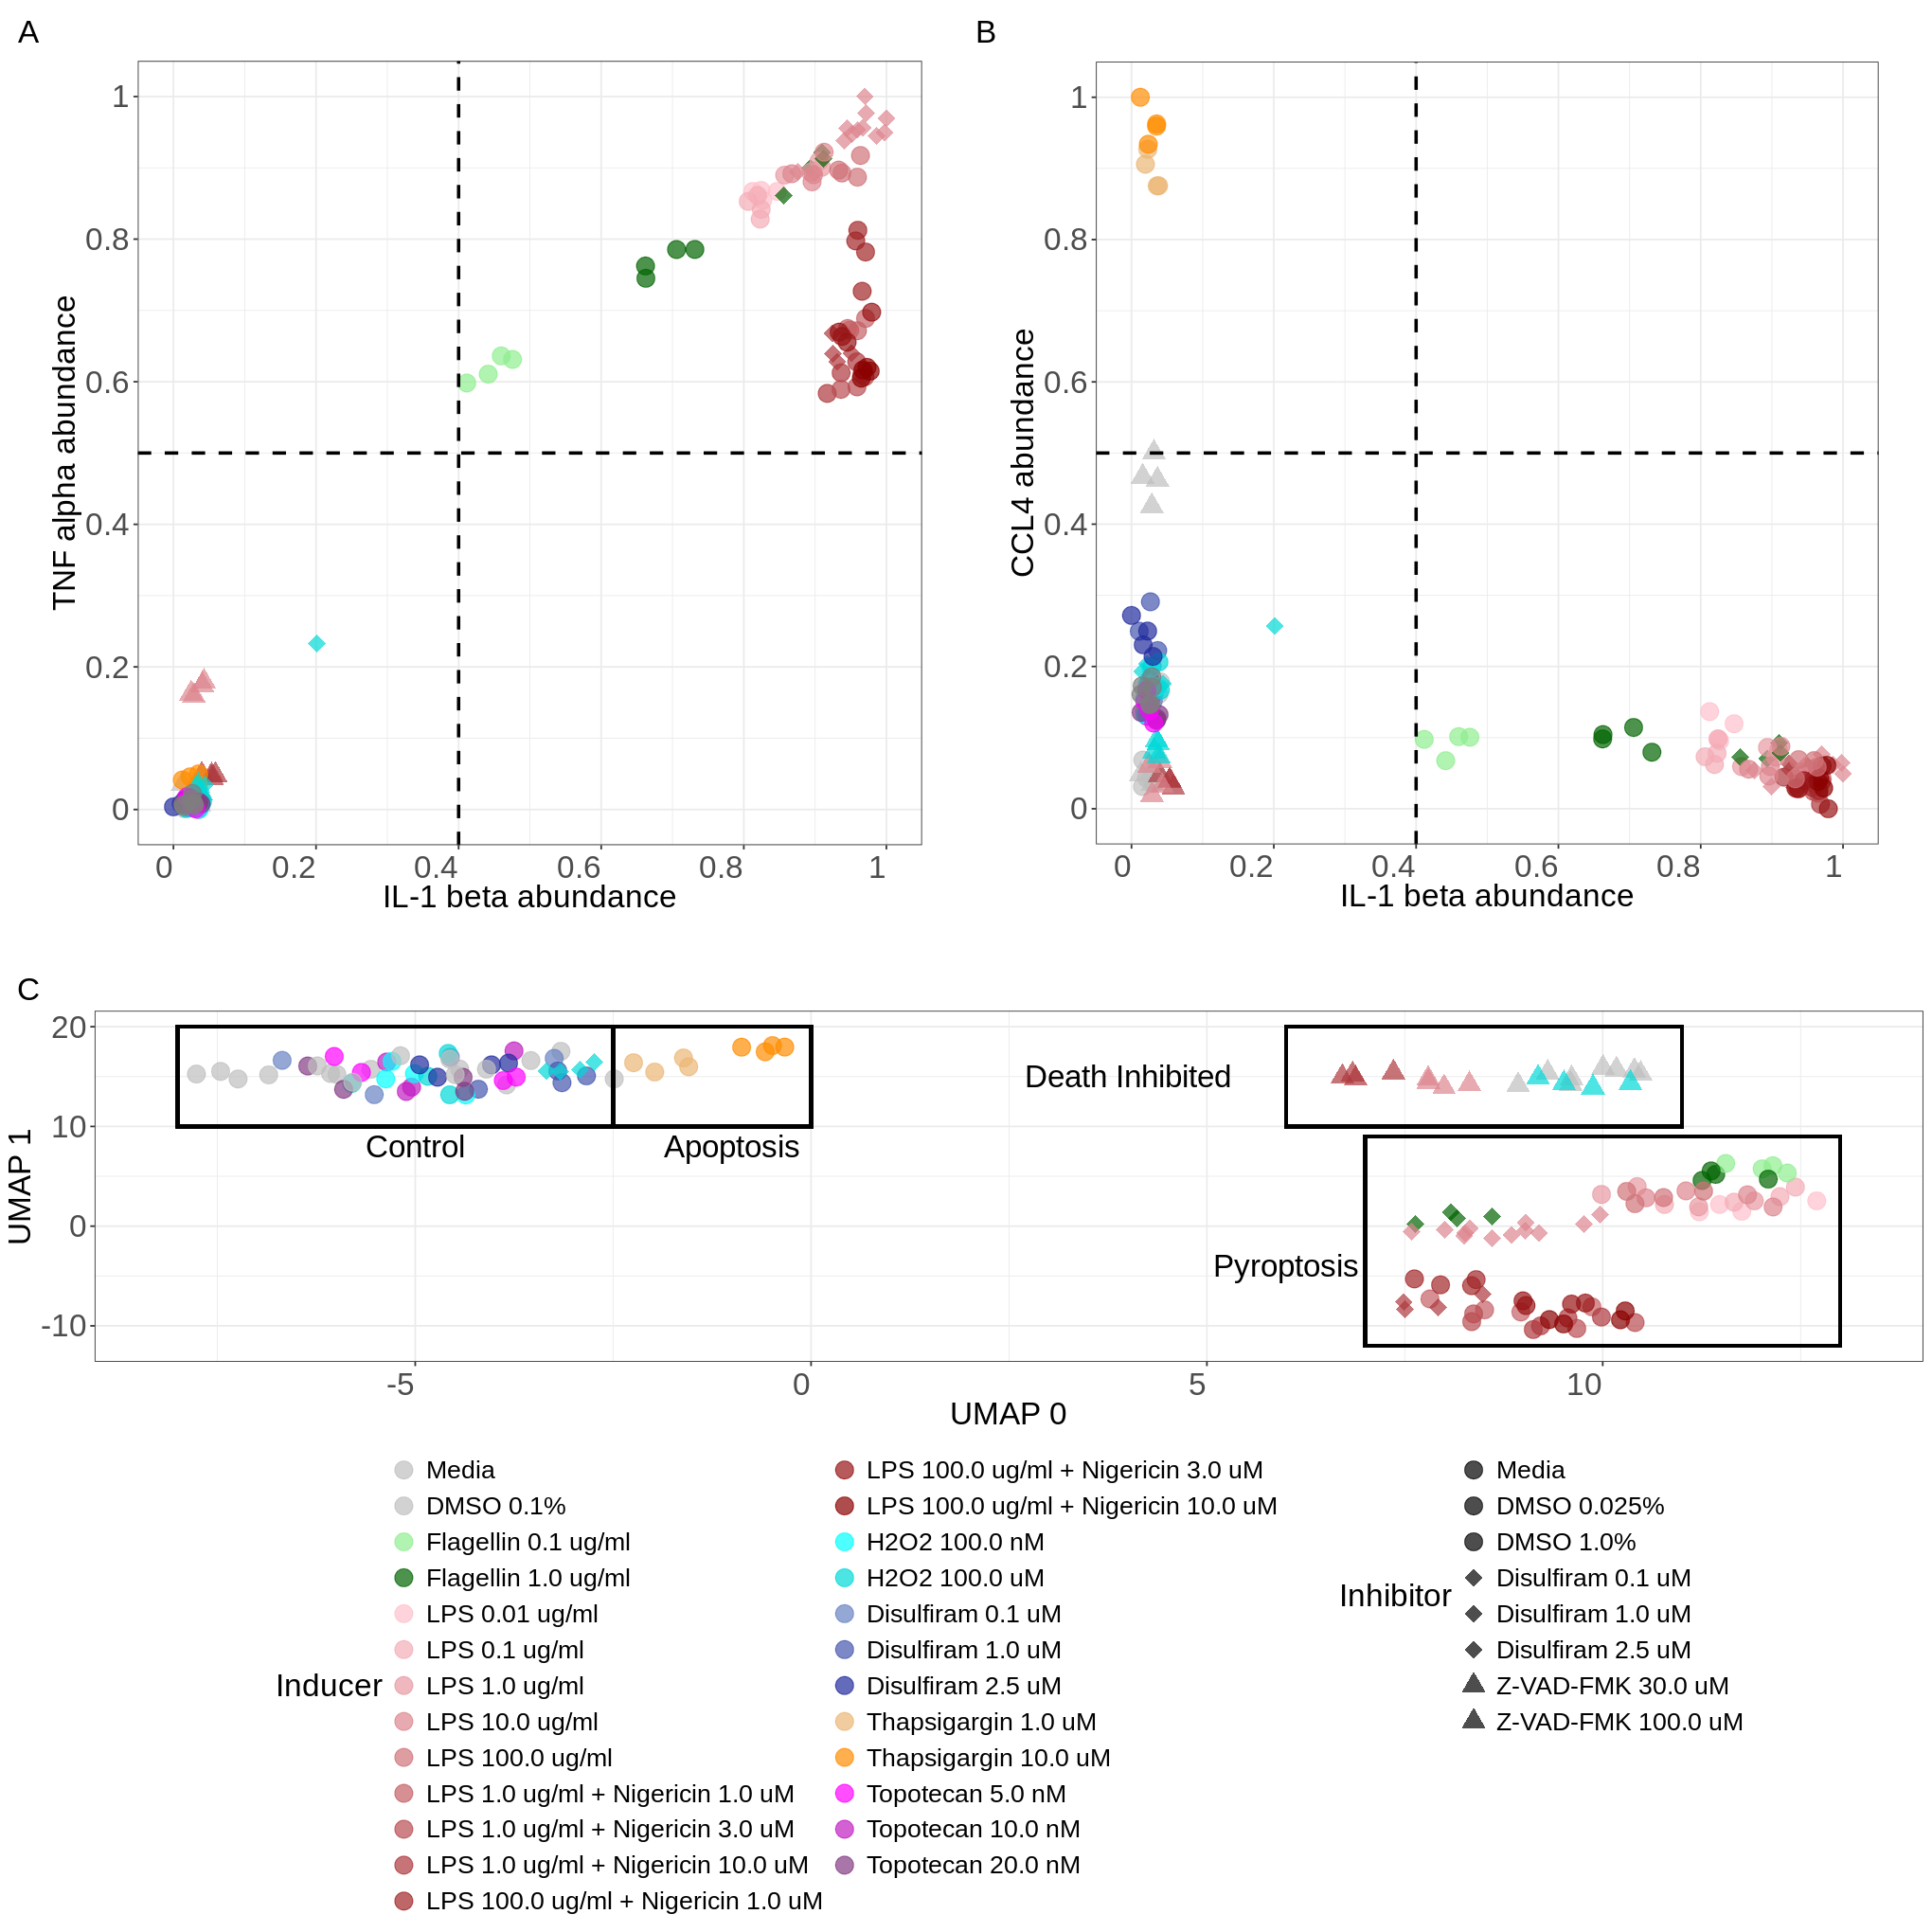

In [36]:
# set the design of the plots in the figure
# Where each letter represents a plot by order defined and the # represents a blank space
# each row represents a proportion of the total plot size
# some plots may be on multiple rows or columns
# plots can be proportioned by adding more letters to the row or column
design <-  "AABB
            AABB
            AABB
            CCCC
            CCCC
            CCCC
            "

# set plot size
width <- 17
height <- 17
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)

# sfig_pt1
sfig_pt1 <- (
    wrap_elements(full = heatmap_cytokines)
    + theme(plot.tag = element_text(size = 20))
)
sfig_pt1

# sfig_pt2
sfig_pt2 <- (
    wrap_elements(full = cytokine_scatter_plot2)
    + wrap_elements(full = cytokine_scatter_plot1)

    + wrap_elements(full = UMAP_plot)
    + plot_layout(design = design, widths = c(0.3,15), heights = c())
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 20))
)
sfig_pt2

# save the figure
ggsave(
    filename = file.path("..","figures","S3.png"),
    plot = sfig_pt1,
    width = width,
    height = height,
    dpi = 600
)
ggsave(
    filename = file.path("..","figures","S2.png"),
    plot = sfig_pt2,
    width = width,
    height = height,
    dpi = 600
)
